# Classifying Handwritten Digits

#### Obtaining and preparing the MNIST dataset 

The images in the MNIST dataset consist of 28×28 pixels, and each pixel is represented by a grayscale
intensity value.<br>
For each image, the pixels are represented as a row with 784 features (28 x 28 pixels)

In [1]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X.values
y = y.astype(int).values

print(f'X shape = {X.shape} - y shape = {y.shape}')

X shape = (70000, 784) - y shape = (70000,)


### Normalizing the pixel into the range -1, 1 (originally 0 to 255)

The reason is that the gradient-based optimization is more stable under these condition.
While working with images put the pixels into the range -1, 1 is a common approach

In [2]:
X = ((X / 255.) - .5) * 2

#### Divide the dataset into training and testing
Creating a training, validation and test subsets

In [3]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, stratify=y, random_state=123)

X_train, X_validation, y_train, y_validation = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

### Implementing a Multilayer Perceptron (MLP)
Importing our Neural Network

In [4]:
from NeuralNetMLP import NeuralNetMLP, init_to_onehot


# model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)


#### Coding the neural network training loop

In [5]:
import numpy as np

num_epochs = 50
minibatch_size = 100

# Separate our dataset in batch of 100 rows to allow us to perform the stochastic gradient descent training
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]


#### Define the loss function
We will use the MSE 

In [6]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = init_to_onehot(targets, num_labels)
    return np.mean((onehot_targets - probas) ** 2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

#### Computing MSE and Accuracy 
We will compute the MSE and Accuracy incrementally by iterating over the dataset one mini-batch at time, to be more memory efficient.

In [7]:
def compute_mse_and_accuracy(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_predictions, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        # Calcolo della loss MSE
        loss = mse_loss(targets, probas, num_labels)
        mse += loss * features.shape[0]

        # Calcolo delle predizioni corrette
        correct_predictions += np.sum(predicted_labels == targets)
        num_examples += targets.shape[0]

    mse /= num_examples
    accuracy_val = correct_predictions / num_examples
    return mse, accuracy_val

### Implementing the training loop

In [8]:
def train(model, X_train, y_train, X_validation, y_validation, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_training_accuracy = []
    epoch_validation_accuracy = []
    
    for epoch in range(num_epochs):
        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        
        for X_train_mini, y_train_mini in minibatch_gen:
            # Compute outputs
            a_h, a_out = model.forward(X_train_mini)
            
            # Compute gradients
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)
            
            # Update weights
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        # Epoch logging
        train_mse, train_accuracy = compute_mse_and_accuracy(model, X_train, y_train)
        valid_mse, valid_accuracy = compute_mse_and_accuracy(model, X_validation, y_validation)
        
        train_accuracy, valid_accuracy = train_accuracy*100, valid_accuracy*100
        epoch_training_accuracy.append(train_accuracy)
        epoch_validation_accuracy.append(valid_accuracy)
        epoch_loss.append(train_mse)
        
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d}'
              f'| Train MSE: {train_mse:.2f}'
              f'| Train Accuracy: {train_accuracy:.2f}'
              f'| Valid Accuracy: {valid_accuracy:.2f}')
        
    return epoch_loss, epoch_training_accuracy, epoch_validation_accuracy

### Executing the training

In [19]:
np.random.seed(123)
model = NeuralNetMLP(num_features=784, num_hidden=50, num_classes=10)
epoch_loss, epoch_training_accuracy, epoch_validation_accuracy = train(model, X_train, y_train, X_validation, y_validation, num_epochs=50, learning_rate=0.1)


(50, 784)
Epoch: 001/050| Train MSE: 0.05| Train Accuracy: 75.82| Valid Accuracy: 75.80
Epoch: 002/050| Train MSE: 0.03| Train Accuracy: 86.14| Valid Accuracy: 85.64
Epoch: 003/050| Train MSE: 0.02| Train Accuracy: 88.36| Valid Accuracy: 88.36
Epoch: 004/050| Train MSE: 0.02| Train Accuracy: 89.56| Valid Accuracy: 89.58
Epoch: 005/050| Train MSE: 0.02| Train Accuracy: 90.30| Valid Accuracy: 90.38
Epoch: 006/050| Train MSE: 0.02| Train Accuracy: 90.72| Valid Accuracy: 91.00
Epoch: 007/050| Train MSE: 0.02| Train Accuracy: 91.20| Valid Accuracy: 91.18
Epoch: 008/050| Train MSE: 0.02| Train Accuracy: 91.56| Valid Accuracy: 91.34
Epoch: 009/050| Train MSE: 0.01| Train Accuracy: 91.89| Valid Accuracy: 91.66
Epoch: 010/050| Train MSE: 0.01| Train Accuracy: 92.09| Valid Accuracy: 91.92
Epoch: 011/050| Train MSE: 0.01| Train Accuracy: 92.38| Valid Accuracy: 92.18
Epoch: 012/050| Train MSE: 0.01| Train Accuracy: 92.55| Valid Accuracy: 92.24
Epoch: 013/050| Train MSE: 0.01| Train Accuracy: 92.69

### Evaluating the neural network performance   

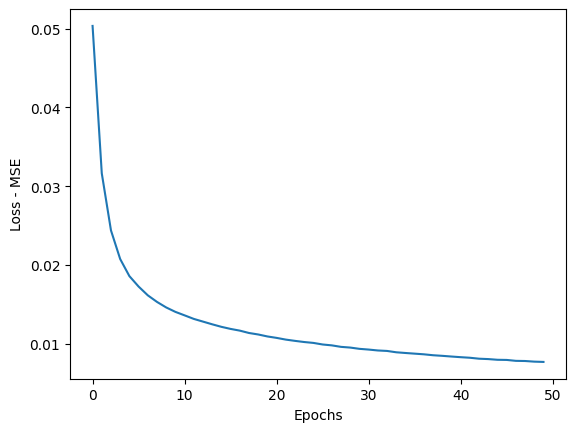

In [20]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.show()

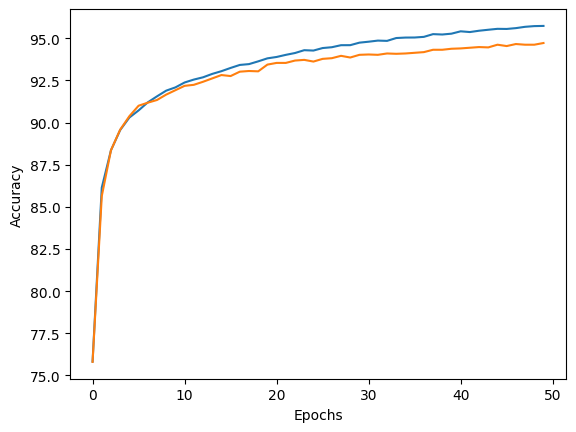

In [21]:
plt.plot(epoch_training_accuracy)
plt.plot(epoch_validation_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Evaluate generalization performance on the test dataset

In [22]:
test_mse, test_acc = compute_mse_and_accuracy(model, X_test, y_test)
print(f'Test Accuracy: {test_acc*100:.2f}')

Test Accuracy: 94.70
